In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [4]:
full_data = pd.read_csv("data/hotel_bookings.csv")

In [5]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

In [10]:
# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
categorical_names = {}
for feature in cat_features:
    col = X[[feature]]
    cat_transformer = SimpleImputer(strategy="constant", fill_value="Unknown")
    col = cat_transformer.fit_transform(col)
    X[feature] = col
    le = LabelEncoder()
    le.fit(X[[feature]])
    X[[feature]] = le.transform(X[[feature]])
    categorical_names[feature] = le.classes_

# Preprocessing
num_transformer = SimpleImputer(strategy="constant")

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features)],
                                remainder = 'passthrough')

/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

In [11]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
indicators = ["recall", "accuracy", "roc auc", "f1"]
models_summary = pd.DataFrame(columns = indicators) 
# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_validate(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring=['recall', 'accuracy', 'roc_auc', 'f1'],
                                 n_jobs=-1)
    models_summary.loc[name]=[np.mean(cv_results["test_recall"]), np.mean(cv_results["test_accuracy"]), 
                          np.mean(cv_results["test_roc_auc"]), np.mean(cv_results["test_f1"])]
    

In [12]:
models_summary

,recall,accuracy,roc auc,f1
DT_model,0.768597,0.824449,0.816120,0.764305
RF_model,0.761633,0.867769,0.932350,0.810125
LR_model,0.537982,0.752651,0.780773,0.617023
XGB_model,0.706440,0.845330,0.912489,0.771857


In [13]:
# Wczytanie i przygotowanie danych 
full_data = pd.read_csv("data/hotel_bookings.csv")
full_data["agent"] = full_data["agent"].astype(str)
treshold = 0.005 * len(full_data)
agents_to_change = full_data['agent'].value_counts()[full_data['agent'].value_counts() < treshold].index
full_data.loc[full_data["agent"].isin(agents_to_change), "agent"] = "other"

countries_to_change = full_data['country'].value_counts()[full_data['country'].value_counts() < treshold].index
full_data.loc[full_data["country"].isin(countries_to_change), "country"] = "other"


# Określenie cech uwzględnionych w modelu
num_features = ["lead_time", "arrival_date_week_number",
                "stays_in_weekend_nights", "stays_in_week_nights", 
                "adults", "previous_cancellations",
                "previous_bookings_not_canceled",
                "required_car_parking_spaces", "total_of_special_requests", 
                "adr", "booking_changes"]

cat_features = ["hotel", "market_segment", "country", 
                "reserved_room_type",
                "customer_type", "agent"]

features = num_features + cat_features

# Podział na zmienne wyjaśniające i target
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

categorical_names = {}
for feature in cat_features:
    col = X[[feature]]
    cat_transformer = SimpleImputer(strategy="constant", fill_value="Unknown")
    col = cat_transformer.fit_transform(col)
    X[feature] = col
    le = LabelEncoder()
    le.fit(X[[feature]])
    X[[feature]] = le.transform(X[[feature]])
    categorical_names[feature] = le.classes_

# Preprocessing
num_transformer = SimpleImputer(strategy="constant")

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features)],
                                remainder = 'passthrough')

/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/anna/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

In [14]:
# Stworzenie modelu
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=42)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42)

model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'adr',
                         

In [15]:
# get cross validation score for eenh model
cv_results = cross_validate(model_pipe,
                            X, y, 
                            cv=split,
                            scoring=['recall', 'accuracy', 'roc_auc', 'f1'],
                            n_jobs=-1)
models_summary.loc["RF_model_enh"]=[np.mean(cv_results["test_recall"]), np.mean(cv_results["test_accuracy"]), 
                                    np.mean(cv_results["test_roc_auc"]), np.mean(cv_results["test_f1"])]

In [16]:
models_summary=models_summary.reset_index()
models_summary.rename(columns={"index":"model"}, inplace=True)
models_summary.style.apply(lambda x: ["background-color: yellow"]*5 if ("RF_model_enh"== x["model"]) else ["background-color: white"]*5, 'columns')


,model,recall,accuracy,roc auc,f1
0,DT_model,0.768597,0.824449,0.816120,0.764305
1,RF_model,0.761633,0.867769,0.932350,0.810125
2,LR_model,0.537982,0.752651,0.780773,0.617023
3,XGB_model,0.706440,0.845330,0.912489,0.771857
4,RF_model_enh,0.819549,0.887721,0.955218,0.843928


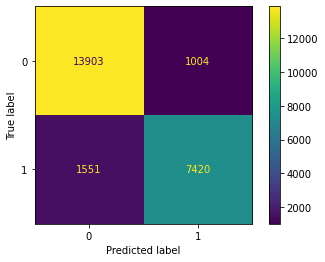

In [17]:
plot_confusion_matrix(model_pipe, X_test, y_test)  